In [1]:
import sys

sys.path.append("../src")

In [2]:
import time

import fitpredictgo as FPG
import joblib
import pandas as pd
from analysis import (
    plot_confusion_matrix,
    plot_prc_auc_curve,
    plot_roc_auc_curve,
)
from fitpredictgo import FitPredictGo, Results

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [4]:
data = pd.read_csv("../data/clean_data.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               381 non-null    int64  
 1   systolic_bp       381 non-null    int64  
 2   diastolic_bp      381 non-null    int64  
 3   glucose_level     381 non-null    float64
 4   body_temperature  381 non-null    float64
 5   heart_rate        381 non-null    int64  
 6   risk_level        381 non-null    object 
 7   age_group         381 non-null    object 
 8   pressure_group    381 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 26.9+ KB


## Определение условий разработки моделей

**Постановка задачи**

В результате проведенной работы по анализу данных и анализа задачи заказчика определено, что в работе необходимо решить задачу мультиклассовой классификации - необходимо спрогнозировать категориальный признак, отражающий степень риска для здоровья беременной женщины в зависимости от ее здоровья.

Все возможные риски определены, как одинаково важные. Имеется незначительный дисбаланс классов, который не должен оказать влияния на обучение моделей МО. Однако, будем использовать параметр class_weight='balanced' в алгоритмах, которые могут его учесть.

Для решения задачи построим несколько моделей. В качестве бейзлайн модели используем линейную модель - логистическую регрессию.

**Выбор метрики**

Требования заказчика к метрике качества модели не установлены.  

Учитывая, что у в данных имеется дисбаланс и все классы одинаково важны, необходимо выбрать метрику для сравнения моделей, которая будет учитывать дисбаланс и обеспечивать адекватную оценку качества моделей.

Метрика accuracy может показать высокие значения при высокой точности предсказаний мажорного класса, когда ошибки предсказаний минорного класса не сильно снизят метрику. В связи с этим, подходящей метрикой является F1. F1 является гармоническим средним между precision и recall и учитывает как ложно-положительные, так и ложноотрицательные результаты. Наша задача - максимизировать F1, балансируя precision и recall. 

При наличии дисбаланса используем её вариацию F1-weighted, так как она учитывает важность каждого класса в зависимости от его представленности.

Кроме того, целесообразно оценить общее качество моделей в способности различать классы. Для этого оценим метрику ROC-AUC и построим соответствующие графики.

**Необходимый уровень метрики**

Заказчиком не установлены требования к метрикам. В связи с этим, оценим указанные метрики для Dummy модели, предсказывающей случайные значения, а также построим простую бейзлайн модель для проверки возможности улучшить метрику Dummy модели. В будущем постараемся добиться лучших значений метрик для других моделей.

**Дополнительные условия**

Заказчиком не установлены дополнительные критерии оценки качества моделей: время обучения модели и время предсказания модели.

Однако, результаты моделирования планируется применить в приложении с использованием streamlit. В связи с этим, целесообразно замерять указанные характеристики и учесть их при выборе лучше модели.

**Описание подходов к моделированию**

На основании сделанных выводов и поставленных задач на основном этапе моделирования выполним построение следующих моделей:
1. **DummyClassifier()** - модель для уточнения минимальной метрики.
2. **LogisticRegression()** - простая бейзлайн модель.

Для каждой модели:
1. Раздели данные на тренировочную и тестовую выборки.
2. Построим пайп-лайн предобработки данных с учетом сделанных ранее выводов EDA анализа. 
3. Обучим модель и проверим ее качество с использованием кросс-валидации. При этом, зафиксируем среднее время обучения на тренировочных данных, предсказания на валидационных данных.
4. Зафиксируем значения выбранной метрики по результатам кросс-валидации.
5. Простым подбором гиперпараметров постараемся улучшить качество бейзлайн модели.

Поток обучения будем реализовывать с использованием ранее подготовленного класса FitPredictGo, сохранение результатов обучения с использованием класса Result. 

## Подготовка данных 

Определим признаки для обучения и целевой признак

In [6]:
original_cat_features = []

original_num_features = [
    "age",
    "systolic_bp",
    "diastolic_bp",
    "glucose_level",
    "body_temperature",
    "heart_rate",
]

new_cat_features = ["age_group", "pressure_group"]

new_num_features = []

target = "risk_level"

cat_features = original_cat_features + new_cat_features
num_features = original_num_features + new_num_features

In [7]:
X_train, y_train, X_test, y_test = FPG.prepare_split(
    data, target, columns=cat_features + num_features, random_state=0
)
print(
    f"{X_train.shape=}",
    f"{y_train.shape=}",
    f"{X_test.shape=}",
    f"{y_test.shape=}",
    sep="\n",
)

X_train.shape=(304, 8)
y_train.shape=(304,)
X_test.shape=(77, 8)
y_test.shape=(77,)


In [8]:
X_train.head()

,age_group,pressure_group,age,systolic_bp,diastolic_bp,glucose_level,body_temperature,heart_rate
206,older age,normal,60,120,80,6.9,98.0,76
67,medium age,normal,23,130,70,6.9,98.0,70
43,medium age,hypotension,23,90,60,7.5,98.0,76
60,medium age,normal,29,130,70,6.7,98.0,78
112,younger age,hypotension,17,90,63,6.9,101.0,70


In [9]:
y_train.head()

206    low risk
67     mid risk
43     low risk
60     mid risk
112    mid risk
Name: risk_level, dtype: object

С учетом сделанных ранее выводов сформируем пайплайн кодировщика OneHotEncoder().

In [10]:
ohe_pipe = Pipeline(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
        )
    ]
)

Установим дополнительную константу для указания количества блоков для кросс-валидации.

In [11]:
cv_folds = 5

In [12]:
scoring = "f1_weighted"

## Разработка моделей

Выполним шаги в соответствии с планом, определенным в предыдущем шаге.

Определим перечень моделей для обучения. В словарь в будущем внесем результаты обучения моделей.

In [13]:
names = {
    "DummyClassifier()": None,
    "LogisticRegression()": None,
}

Построим пайп-лайны предобработки данных

In [14]:
preprocessor = ColumnTransformer(
    [
        (
            "ohe",
            OneHotEncoder(
                drop="first", handle_unknown="infrequent_if_exist", sparse_output=False
            ),
            cat_features,
        ),
        ("num", StandardScaler(), num_features),
    ],
    remainder="passthrough",
)

In [15]:
preprocessors = {
    "DummyClassifier()": [preprocessor],
    "LogisticRegression()": [preprocessor],
}

Определим инициализационные модели для кросс-валидации

In [16]:
models = {
    "DummyClassifier()": DummyClassifier(),
    "LogisticRegression()": LogisticRegression(class_weight="balanced"),
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [17]:
%%time

res = Results()

for name in names.keys():
    print(f"{name}, CV")
    model = FitPredictGo(name, scoring)
    start = time.time()
    result = model.fit_cv(
        preprocessors[name], models[name], X_train, y_train, cv_folds, True
    )
    time_cv = round(time.time() - start, 3)
    res.update(result)
    print(f"--> Done. CV Time = {time_cv} секунд")
    names[name] = model
    print()

print("All Done")

sorted_results = res.df.sort_values(
    by="Среднее значение метрики при CV", ascending=False
)
sorted_results

DummyClassifier(), CV


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['age_group',
                                                   'pressure_group']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp',
                                                   'glucose_level',
                                                   'body_temperature',
                                                   'heart_rate'])])),
                ('dummyclassifier', DummyClassifier())])

--> Done. CV Time = 0.116 секунд

LogisticRegression(), CV


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['age_group',
                                                   'pressure_group']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'systolic_bp',
                                                   'diastolic_bp',
                                                   'glucose_level',
                                                   'body_temperature',
                                                   'heart_rate'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

--> Done. CV Time = 0.155 секунд

All Done
CPU times: total: 281 ms
Wall time: 277 ms


,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
1,LogisticRegression(),0.015,0.006,0.690,0.045
0,DummyClassifier(),0.009,0.007,0.374,0.007


#### Вывод по разделу "Разработка моделей"

В результате анализа результатов работы получена бейзлайн модель с итоговой метрикой F1-weighted = 0,690. Относительно Dummy модели мы получили увеличение почти в 2 раза.

## Оценка качества работы лучшей модели на тестовой выборке

Оценим качество модели на тестовой выборке и выведем на экран матрицу ошибок на трейне, тесте и соответствующие графики ROC-AUC и PRC-AUC.

Определим бейзлайн модель

In [18]:
baseline_model = names["LogisticRegression()"].get_best_estimator("cv")

Выполним предсказания на трейне

In [19]:
pred_train = baseline_model.predict(X_train)
proba_train = baseline_model.predict_proba(X_train)

Отразим отчет о классификации на трейне

In [20]:
report_train = classification_report(y_train, pred_train)
print(report_train)

              precision    recall  f1-score   support

   high risk       0.85      0.85      0.85        80
    low risk       0.82      0.72      0.77       163
    mid risk       0.39      0.52      0.45        61

    accuracy                           0.71       304
   macro avg       0.69      0.70      0.69       304
weighted avg       0.74      0.71      0.72       304



В результате классификации видим, что "Высокий риск" наша модель научилась предсказывать довольно неплохо, также как и "Низкий риск". В то же время, "Средний риск" модель научилась предсказывать значительно хуже. 
Необходимо отметить, что баланс классов смещен в сторону "Низкого риска", который предсказывается не очень хорошо.
Предполагается, что линейная модель показала не плохой, но и не лучший результат. В будущем необходимо провести эксперимент по внедрению регуляризации и использованию других моделей.

Отобразим матрицу ошибок

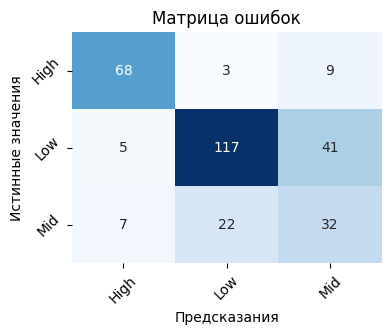

In [21]:
cnf_matrix_train = confusion_matrix(y_train, pred_train)
plot_confusion_matrix(cnf_matrix_train, ["High", "Low", "Mid"])

Из этой матрицы ошибок мы видим, что модель справляется хорошо с классификацией объектов класса "Высокий риск", но имеет весьма большие трудности с классификацией объектов класса "Средний риск". "Средний риск" предсказывает довольно неплохо, но довольно часто путается со "Средним риском". А при предсказании "Среднего риска" модель чаще путает его с "Низким риском".
Необходимо обратить внимание на работу с классом "Средний риск".

Оценим значение ROC-AUC

In [22]:
roc_auc_train = roc_auc_score(
    y_train, proba_train, multi_class="ovo", average="weighted"
)
roc_auc_train

0.8470632812624063

Значение ROC-AUC не очень высоко. Модель не очень хорошо различает классы. Отобразим кривые ROC-AUC на графике.

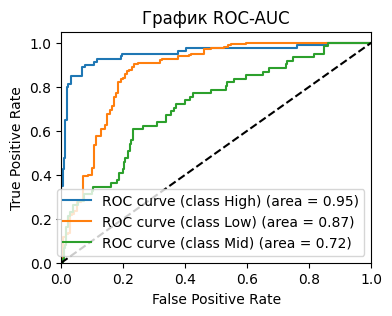

In [23]:
plot_roc_auc_curve(y_train, proba_train, ["High", "Low", "Mid"])

Аналогично прослеживается ситуация, что класс "Средний риск" значительно хуже различается нашей моделью. Та же самая ситуация будет представлена на графике PRC-AUC.

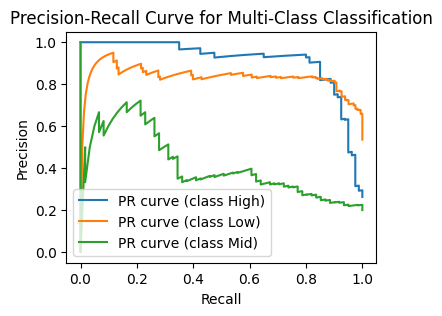

In [24]:
plot_prc_auc_curve(y_train, proba_train, ["High", "Low", "Mid"])

Выполним анализ для тестовой выборки

In [25]:
pred_test = baseline_model.predict(X_test)
proba_test = baseline_model.predict_proba(X_test)
report_test = classification_report(y_test, pred_test)
print(report_test)

              precision    recall  f1-score   support

   high risk       0.80      0.57      0.67        21
    low risk       0.80      0.80      0.80        41
    mid risk       0.29      0.40      0.33        15

    accuracy                           0.66        77
   macro avg       0.63      0.59      0.60        77
weighted avg       0.70      0.66      0.68        77



c:\Users\filat\Documents\projects\maternal_health_risk\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\filat\Documents\projects\maternal_health_risk\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


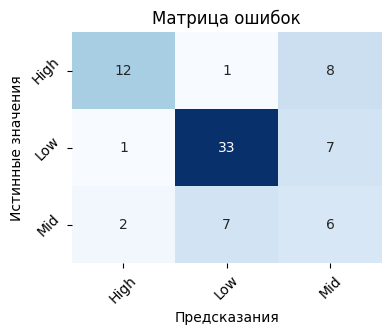

In [26]:
cnf_matrix_test = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cnf_matrix_test, ["High", "Low", "Mid"])

In [27]:
roc_auc_test = roc_auc_score(y_test, proba_test, multi_class="ovo", average="weighted")
roc_auc_test

0.843392612033727

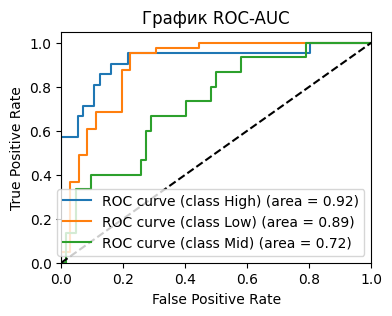

In [28]:
plot_roc_auc_curve(y_test, proba_test, ["High", "Low", "Mid"])

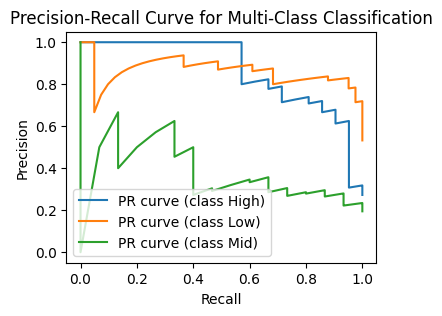

In [29]:
plot_prc_auc_curve(y_test, proba_test, ["High", "Low", "Mid"])

#### Вывод по разделу "Разработка моделей"

Анализ результатов бейзлайн модели показал, что модель, построенная с использованием алгоритма Логистической регрессии в условиях нашего небольшого дисбаланса классов уверенно предсказывает класс "Высокий риск" (27% данных), чуть хуже класс "Низкий риск" (53% данных) и очень плохо класс "Средний риск" (23% данных).
В этой связи, можно отметить, что дисбаланс классов оказывает небольшое влияние, тем более в условиях применения взвешивания классов.

Для улучшения качества модели предлагается несколько гипотез, реализация которых может помочь в повышении качества предсказаний:
1. Оценим потенциал гиперпараметров логистической регрессии.
2. Применим модель решающего дерева и поработаем с его гиперпараметрами.
3. Применим ансамблевые методы - случайный лес и градиентный бустинг, которые более устойчивы к переобучению и имеют потенциал для лучшей разделяющей способности классов.
4. Проанализируем примеры, на которых модель путает один класс с другим, и попробуем понять причины ошибок.

## Сохранение модели и данных для дальнейшей работы

Для проведения дальнейших экспериментов сохраним полученную бейзлайн модель и все данных, используемые для обучения.
В будущем мы будем проверять гипотезы по влиянию различных признаков на предсказательную силу модели, для чего потребуются аналогичные данные для обучения и теста.
Бейзлайн модель мы используем, чтобы создать первую версию приложения на streamlit.

In [30]:
joblib.dump(baseline_model, "../models/baseline_model.joblib")

['../models/baseline_model.joblib']

In [31]:
X_train.to_csv("../data/baseline/X_train.csv", index=False)
X_test.to_csv("../data/baseline/X_test.csv", index=False)
y_train.to_csv("../data/baseline/y_train.csv", index=False)
y_test.to_csv("../data/baseline/y_test.csv", index=False)